In [1]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

/Users/kewu/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load Data

In [34]:
# load training and test data
import pickle
import numpy as np
from sklearn.preprocessing import label_binarize
import cv2 as cv

# resize input data to be 125*125
size = (125, 125)

data_train = pickle.load(open("data/image_data_train224.pkl","rb"))
data_test = pickle.load(open("data/image_data_test224.pkl","rb"))
class_list = pickle.load(open("data/class_list.pkl", "rb"))

# the data structure in image_data_train224.pkl
# it is a list of (image, label) tuple, each image is a matrix of (224, 224, 3)

X_train = np.array([cv.resize(x[0], size)/255. for x in data_train])
X_test = np.array([cv.resize(x[0], size)/255. for x in data_test])

Y_train = np.array([x[1] for x in data_train])
Y_test = np.array([x[1] for x in data_test])

print X_train.shape
print Y_train.shape
print X_test.shape
print Y_test.shape
print X_train.max()
print X_train.min()

(93, 125, 125, 3)
(93,)
(25, 125, 125, 3)
(25,)
1.0
0.0


### Load Model

In [4]:
save_dir = os.path.join('saved_models')
model_name1 = 'keras_lfw_trained_model.h5'
model_name2 = 'keras_lfw_trained_model_150_mobileNet.h5'

# model 1, simple model, part of VGG, accuracy on LFW: 0.51, training hours: 10h
# model 2, mobileNet, accuracy on LFW: 0.64, training hours: 14h

In [5]:
from keras.models import load_model
model_path = os.path.join(save_dir, model_name1)
model_simple = load_model(model_path)

In [6]:
model_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 125, 125, 32)      896       
_________________________________________________________________
activation_25 (Activation)   (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 123, 123, 32)      9248      
_________________________________________________________________
activation_26 (Activation)   (None, 123, 123, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 61, 61, 64)        18496     
__________

In [7]:
for l in model_simple.layers:
    print(l.name)

conv2d_17
activation_25
conv2d_18
activation_26
max_pooling2d_9
dropout_13
conv2d_19
activation_27
conv2d_20
activation_28
max_pooling2d_10
dropout_14
flatten_5
dense_9
activation_29
dropout_15
dense_10
activation_30


In [8]:
import keras.backend as K
layer_name = 'activation_29'
get_embedding_layer_output = K.function([model_simple.layers[0].input, K.learning_phase()],[model_simple.get_layer(layer_name).output])

In [9]:
import numpy as np
np.random.seed(1234)
x = np.random.rand(1,125,125,3)
layer_output_test = get_embedding_layer_output([x, 0])[0]

In [10]:
layer_output_test[0,:10]

array([0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 4.329412, 0.      , 0.      ], dtype=float32)

(93, 512)
(25, 512)


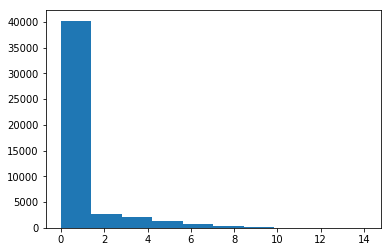

In [38]:
X_train_embedding = get_embedding_layer_output([X_train, 0])[0]
X_test_embedding = get_embedding_layer_output([X_test, 0])[0]

print X_train_embedding.shape
print X_test_embedding.shape

plt.hist(X_train_embedding.ravel())
plt.show()

In [55]:
from sklearn.linear_model import LogisticRegression as LR

# it is identical to only optimize over the top layer
# previously the best we can get is 0.72 accuracy

model = LR()
model.fit(X_train_embedding, Y_train)
print "training accuracy: ", model.score(X_train_embedding, Y_train)
print "test accuracy: ", model.score(X_test_embedding, Y_test)

training accuracy:  1.0
test accuracy:  0.84


In [13]:
from keras.applications import mobilenet

model_path_mobileNet = os.path.join(save_dir, model_name2)
model_mobilenet = load_model(model_path_mobileNet, custom_objects={
                   'relu6': mobilenet.relu6,
                   'DepthwiseConv2D': mobilenet.DepthwiseConv2D})

print model_mobilenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 125, 125, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 127, 127, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 63, 63, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 63, 63, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 63, 63, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 65, 65, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 63, 63, 32)        288       
__________

In [17]:
# Note:
# batch normalization: 
# To increase the stability of a neural network, batch normalization normalizes the output of a previous 
# activation layer by subtracting the batch mean and dividing by the batch standard deviation.

In [1]:
import keras.backend as K
print K.learning_phase()
layer_name_mobilenet = 'global_average_pooling2d_1'
get_embedding_layer_output_mobilenet = K.function([model_mobilenet.layers[0].input, K.learning_phase()],[model_mobilenet.get_layer(layer_name_mobilenet).output])

/Users/kewu/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensor("keras_learning_phase:0", shape=(), dtype=bool)


NameError: name 'model_mobilenet' is not defined

(93, 1024)
(25, 1024)


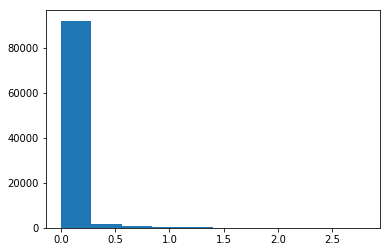

In [37]:
X_train_embedding_mobilenet = get_embedding_layer_output_mobilenet([X_train, 0])[0]
X_test_embedding_mobilenet = get_embedding_layer_output_mobilenet([X_test, 0])[0]

print X_train_embedding_mobilenet.shape
print X_test_embedding_mobilenet.shape

plt.hist(X_train_embedding_mobilenet.ravel())
plt.show()

In [16]:
from sklearn.linear_model import LogisticRegression as LR

# it is identical to only optimize over the top layer

model = LR()
model.fit(X_train_embedding_mobilenet, Y_train)
print "training accuracy: ", model.score(X_train_embedding_mobilenet, Y_train)
print "test accuracy: ", model.score(X_test_embedding_mobilenet, Y_test)

training accuracy:  0.6881720430107527
test accuracy:  0.6


In [42]:
model = LR()
model.fit(X_train.reshape(X_train.shape[0],-1), Y_train)
print "training accuracy: ", model.score(X_train.reshape(X_train.shape[0],-1), Y_train)
print "test accuracy: ", model.score(X_test.reshape(X_test.shape[0],-1), Y_test)

training accuracy:  1.0
test accuracy:  0.88


## conclusion: 
1. pretraining may help deep network training
2. for our case, a noisy pretraining can not beat even logistic regression